In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from erftools.postprocessing import Plotfile

In [3]:
# plotting options
plt.rcParams['font.family'] = 'serif'

import seaborn as sns
colors = sns.color_palette('colorblind')
sns.set_palette(colors)

# Postprocess plotfiles all plotfiles

In [4]:
# combined datasets generated with `plt_to_nc.py`
eqnsets = ['COMP','ANEL']
resolutions = ['CRSE','MED','FINE','FAC4']
sims = {}
for eqns in eqnsets:
    for res in resolutions:
        name = f'{eqns}_{res}'
        sims[name] = xr.open_dataset(f'{name}/combined_pltfiles.nc')

## calc QOIs

In [5]:
def approx_wave_front(ds,thresh=0.99):
    """From max dtheta/dz"""
    front = []
    for ti in ds.coords['t']:
        dtheta = ds['theta'].sel(t=ti).diff('x')
        maxdtheta = dtheta.max()
        if thresh is not None:
            subset = (dtheta >= thresh*maxdtheta)
        else:
            subset = (dtheta == maxdtheta)
        region = dtheta.where(subset).dropna('x',how='all')
        if len(region.coords['x'] > 0):
            xf = region.coords['x'][-1].item()
        else:
            xf = np.nan
        front.append(xf)
    front = xr.DataArray(front,dims=['t'],coords={'t':ds.coords['t']})
    
    return front

In [6]:
def diff_xf(xf,dt=2.5):
    xf = xf.diff('t')
    return xf / dt
    # xf = xf.isel(t=slice(2,None)).assign_coords(t=xf.coords['t'][1:-1]) \
    #    - xf.isel(t=slice(0,-2)).assign_coords(t=xf.coords['t'][1:-1])
    # return xf / (2*dt)

In [7]:
for name,ds in sims.items():
    sims[name]['velmag'] = np.sqrt(ds['x_velocity']**2 + ds['z_velocity']**2)
    
    xf = approx_wave_front(ds)
    dt = np.diff(xf.t.values)[0]
    sims[name]['front_position'] = xf
    sims[name]['front_speed'] = diff_xf(xf,dt)

## check ref sim

In [8]:
refsim = 'COMP_FINE'
dsref = sims[refsim]

In [9]:
dsref['theta'].min(['x','z']).isel(t=-1)

<xarray.DataArray 'theta' ()>
array(290.45521737)
Coordinates:
    t        float64 900.0
    y        float64 ...

In [10]:
dsref.isel(t=-1)[['front_position','front_speed']]

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    t               float64 900.0
    y               float64 ...
Data variables:
    front_position  float64 1.544e+04
    front_speed     float64 15.0

In [11]:
dsref[['x_velocity','front_speed']].max()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    y            float64 ...
Data variables:
    x_velocity   float64 38.3
    front_speed  float64 25.83

In [12]:
dsref['x_velocity'].sel(t=slice(450,600)).max()

<xarray.DataArray 'x_velocity' ()>
array(35.21177267)
Coordinates:
    y        float64 ...

## time hist comparison

COMP_CRSE comp-coarse 0.0033382092996872845 0.014569225962327894 0.01886792452830193
ANEL_CRSE anel-coarse 0.0026159247262083603 0.05498015457597991 0.03514376996805105
COMP_MED comp-medium 0.0002936295174238388 0.0032400191722966884 0.006289308176100607
ANEL_MED anel-medium 0.0006584848817784423 0.03474902412001699 0.031446540880503145
COMP_FINE comp-fine 0.0 0.0 0.0
ANEL_FINE anel-fine 0.0005948600532355755 0.030736823516874692 0.025157232704402538
COMP_FAC4 comp-fac4 4.059599427191347e-05 0.002337931711756706 0.012121212121212078
ANEL_FAC4 anel-fac4 0.0005923002111514006 0.03148550883617233 0.03550295857988153


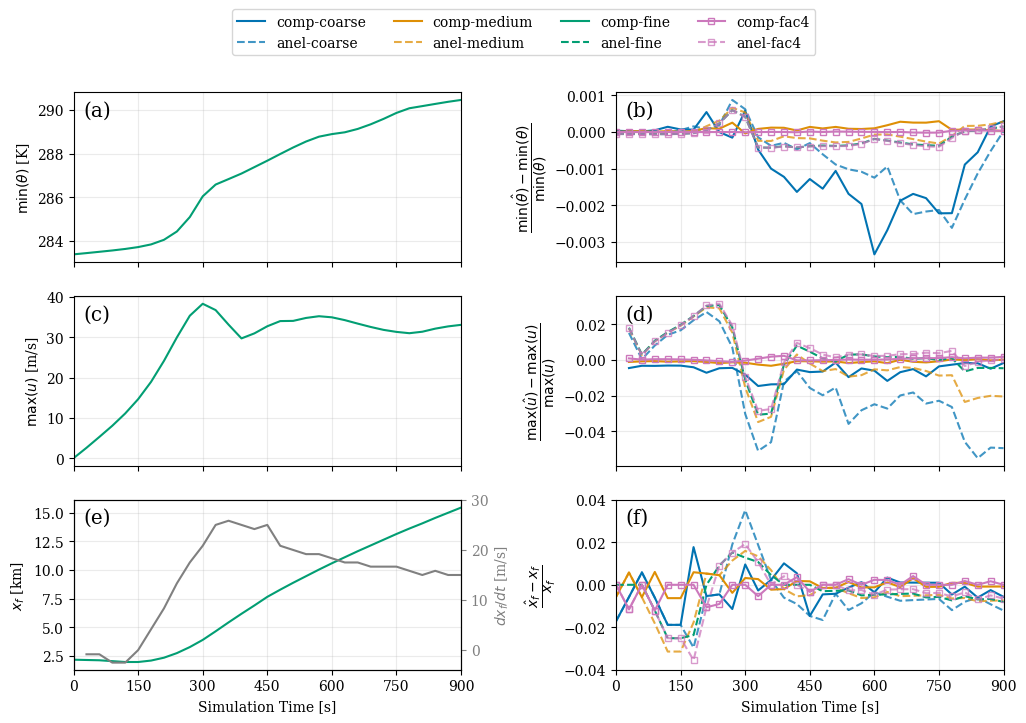

In [13]:
fig,axs = plt.subplots(nrows=3,ncols=2,sharex=True,figsize=(12,7.5))
plt.subplots_adjust(wspace=0.4)

for ires,res in enumerate(resolutions):
    for eqnset in ['COMP','ANEL']:
        name = f'{eqnset}_{res}'
        label = name.lower().replace('_','-').replace('crse','coarse').replace('med','medium')

        # setup styles
        if res.endswith('FAC4'):
            # specific color for AMR
            style = dict(color=colors[4],
                         marker='s',
                         markersize=4,
                         mfc='none')
        else:
            style = dict(color=colors[ires])
        if name not in sims.keys():
            continue
        elif eqnset=='ANEL':
            style['linestyle'] = '--'
            if res != 'FINE':
                style['alpha'] = 0.75

        ds = sims[name]
    
        val = ds['theta'].min([dim for dim in ds.dims if dim != 't'])
        valref = dsref['theta'].min([dim for dim in dsref.dims if dim != 't'])
        theta_metric = (val - valref) / valref
        if name == refsim:
            axs[0,0].plot(dsref.t, valref, **style, label=label)
            axs[0,1].plot([-1], [0], **style, label=label) # DUMMY LINE FOR LEGEND

        uvar = 'x_velocity' # 'velmag'
        val = ds[uvar].max([dim for dim in ds.dims if dim != 't'])
        valref = dsref[uvar].max([dim for dim in dsref.dims if dim != 't'])
        vel_metric = (val - valref) / valref
        if name == refsim:
            axs[1,0].plot(dsref.t, valref, **style, label=label)

        frontvar = 'front_position'
        val = ds[frontvar] / 1000. # [km]
        valref = dsref[frontvar] / 1000. # [km]
        front_metric = (val - valref) / valref
        if name == refsim:
            axs[2,0].plot(dsref.t, valref, **style, label=label)
            axtwin = axs[2,0].twinx()
            axtwin.tick_params(axis='y', labelcolor='0.5', colors='0.5')
            axtwin.plot(dsref.t, dsref['front_speed'], '0.5')
            axtwin.set_ylabel(r'$d x_f/dt$ [m/s]')
            axtwin.yaxis.label.set_color('0.5')
            axtwin.set_ylim((None,30))
        else:
            axs[0,1].plot(ds.t, theta_metric, **style, label=label)
            axs[1,1].plot(ds.t, vel_metric, **style, label=label)   
            axs[2,1].plot(front_metric.t, front_metric, **style, label=label)

        print(name, label,
              np.abs(theta_metric).max('t').item(),
              np.abs(vel_metric).max('t').item(),
              np.abs(front_metric).max('t').item())

axs[0,0].set_ylabel(r'$\min(\theta)$ [K]')
axs[1,0].set_ylabel(r'$\max(u)$ [m/s]')
axs[2,0].set_ylabel(r'$x_f$ [km]')

axs[0,1].legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5,1), bbox_transform=fig.transFigure)
axs[0,1].set_ylabel(r'$\dfrac{\min(\hat{\theta}) - \min(\theta)}{\min(\theta)}$')
axs[1,1].set_ylabel(r'$\dfrac{\max(\hat{u}) - \max(u)}{\max(u)}$')
axs[2,1].set_ylabel(r'$\dfrac{\hat{x}_f - x_f}{x_f}$')
for ax in axs[-1,:]:
    ax.set_xlabel('Simulation Time [s]')
    ax.set_xticks(np.arange(0,901,150))
    ax.set_xlim(0,900)
for ax in axs.ravel():
    ax.grid(alpha=0.25)
axs[2,1].set_ylim((-.04,.04))

label_pos = (0.025, 0.95)
axs[0,0].text(*label_pos, '(a)', transform=axs[0,0].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')
axs[0,1].text(*label_pos, '(b)', transform=axs[0,1].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')
axs[1,0].text(*label_pos, '(c)', transform=axs[1,0].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')
axs[1,1].text(*label_pos, '(d)', transform=axs[1,1].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')
axs[2,0].text(*label_pos, '(e)', transform=axs[2,0].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')
axs[2,1].text(*label_pos, '(f)', transform=axs[2,1].transAxes, fontsize='x-large', horizontalalignment='left', verticalalignment='top')

fig.savefig('density_current_convergence.png',bbox_inches='tight',dpi=150)